**dataset summary**

**1. Setup and Imports**

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# Set the plot style
sns.set_style('whitegrid')

**2. Data Loading**

In [2]:
print("="*70)
print("🔒 INSIDER THREAT DETECTION - DEEP LEARNING")
print("="*70)

# Define data directory and file paths
data_dir = "datasets"
files = {
    "users": os.path.join(data_dir, "users.csv"),
    "logon": os.path.join(data_dir, "logon.csv"),
    "email": os.path.join(data_dir, "email.csv"),
    "device": os.path.join(data_dir, "device.csv")
}

# Load all datasets
print("\n📂 Loading datasets...")
data = {}
for name, path in files.items():
    try:
        df = pd.read_csv(path)
        data[name] = df
        print(f"✅ Loaded {name}: {df.shape}")
    except Exception as e:
        print(f"❌ Error loading {name}: {e}")
        data[name] = None

🔒 INSIDER THREAT DETECTION - DEEP LEARNING

📂 Loading datasets...
✅ Loaded users: (4000, 12)
✅ Loaded logon: (3530285, 5)
✅ Loaded email: (10994957, 12)
✅ Loaded device: (1551828, 6)


**3. Feature Engineering**

**3.1. Logon Features**

In [3]:
print("\n🔧 Engineering behavioral features...")
features = {}

# Process logon data if available
if data['logon'] is not None:
    logon_df = data['logon'].copy()
    logon_df['date'] = pd.to_datetime(logon_df['date'], format='%m/%d/%Y %H:%M:%S', errors='coerce')
    
    # Aggregate logon patterns
    logon_features = logon_df.groupby('user').agg({
        'id': 'count',
        'pc': 'nunique',
        'activity': lambda x: (x == 'Logon').sum()
    }).rename(columns={
        'id': 'total_logon_events',
        'pc': 'unique_pcs_logon',
        'activity': 'logon_count'
    })
    
    # Create time-based features
    logon_df['hour'] = logon_df['date'].dt.hour
    logon_df['day_of_week'] = logon_df['date'].dt.dayofweek
    logon_df['is_weekend'] = logon_df['day_of_week'].isin([5, 6]).astype(int)
    logon_df['is_after_hours'] = ((logon_df['hour'] < 7) | (logon_df['hour'] > 19)).astype(int)
    
    time_features = logon_df.groupby('user').agg({
        'is_weekend': 'sum',
        'is_after_hours': 'sum',
        'hour': ['mean', 'std']
    })
    time_features.columns = ['weekend_logons', 'after_hours_logons', 'avg_logon_hour', 'std_logon_hour']
    
    # Combine logon features
    logon_features = logon_features.join(time_features)
    features['logon'] = logon_features


🔧 Engineering behavioral features...


**3.2. Device Features**

In [4]:
if data['device'] is not None:
    device_df = data['device'].copy()
    device_df['date'] = pd.to_datetime(device_df['date'], format='%m/%d/%Y %H:%M:%S', errors='coerce')

    # Aggregate device usage
    device_features = device_df.groupby('user').agg({
        'id': 'count',
        'pc': 'nunique',
        'activity': lambda x: (x == 'Connect').sum()
    }).rename(columns={
        'id': 'total_device_events',
        'pc': 'unique_pcs_device',
        'activity': 'device_connect_count'
    })

    # Analyze file tree depth
    device_df['file_depth'] = device_df['file_tree'].fillna('').apply(
        lambda x: len(x.split(';')) if x else 0
    )
    
    file_features = device_df.groupby('user')['file_depth'].agg(['mean', 'max', 'std']).rename(columns={
        'mean': 'avg_file_depth',
        'max': 'max_file_depth',
        'std': 'std_file_depth'
    })
    
    # Combine device features
    device_features = device_features.join(file_features)
    features['device'] = device_features

**3.3. Email Features**

In [5]:
if data['email'] is not None:
    email_df = data['email'].copy()
    email_df['date'] = pd.to_datetime(email_df['date'], format='%m/%d/%Y %H:%M:%S', errors='coerce')

    # Aggregate email statistics
    email_features = email_df.groupby('user').agg({
        'id': 'count',
        'pc': 'nunique',
        'activity': lambda x: (x == 'Send').sum(),
        'size': ['mean', 'sum', 'max', 'std']
    })
    email_features.columns = [
        'total_emails', 'unique_pcs_email', 'emails_sent',
        'avg_email_size', 'total_email_size', 'max_email_size', 'std_email_size'
    ]

    # Detect external emails and attachments
    email_df['is_external'] = ~email_df['to'].fillna('').str.contains('@dtaa.com')
    email_df['has_attachments'] = email_df['attachments'].notna().astype(int)
    
    external_features = email_df.groupby('user').agg({
        'is_external': 'sum',
        'has_attachments': 'sum'
    }).rename(columns={
        'is_external': 'external_emails',
        'has_attachments': 'emails_with_attachments'
    })
    
    # Combine email features
    email_features = email_features.join(external_features)
    features['email'] = email_features

**3.4. Final Feature Combination**

In [6]:
# Merge all feature sets
user_features = pd.concat(features.values(), axis=1, join='outer')
user_features = user_features.fillna(0)

# Add user metadata from users.csv
if data['users'] is not None:
    users_df = data['users'].copy().set_index('user_id')
    
    # Encode categorical features
    le = LabelEncoder()
    for col in ['role', 'functional_unit', 'department']:
        if col in users_df.columns:
            users_df[f'{col}_encoded'] = le.fit_transform(users_df[col].fillna('Unknown'))
            
    user_features = user_features.join(
        users_df[['role_encoded', 'functional_unit_encoded', 'department_encoded']], 
        how='left'
    )

user_features = user_features.fillna(0)

# Create derived risk indicator ratios
user_features['email_to_logon_ratio'] = user_features['total_emails'] / user_features['total_logon_events'].replace(0, 1)
user_features['device_to_logon_ratio'] = user_features['total_device_events'] / user_features['total_logon_events'].replace(0, 1)
user_features['external_email_ratio'] = user_features['external_emails'] / user_features['total_emails'].replace(0, 1)
user_features['after_hours_ratio'] = user_features['after_hours_logons'] / user_features['total_logon_events'].replace(0, 1)

print(f"✅ Created {user_features.shape[1]} features for {user_features.shape[0]} users")

✅ Created 29 features for 4000 users


**4. Data Preparation for Autoencoder**

In [7]:
print("\n🔧 Preparing data for training...")
feature_names = user_features.columns.tolist()
user_ids = user_features.index.tolist()
X = user_features.values

# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Data prepared: {X_scaled.shape}")


🔧 Preparing data for training...
✅ Data prepared: (4000, 29)


**5. Autoencoder Model for Anomaly Detection**

**5.1. Build and Train the Model**

In [8]:
print("\n" + "="*70)
print("MODEL 1: AUTOENCODER")
print("="*70)

print("\n🏗️ Building Autoencoder...")

# Define model architecture
input_dim = X_scaled.shape[1]
encoding_dim = 16

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.2)(encoded)
encoded = layers.Dense(encoding_dim, activation='relu', name='encoding')(encoded)

decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.BatchNormalization()(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.BatchNormalization()(decoded)
decoded = layers.Dropout(0.2)(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder_model = Model(inputs=input_layer, outputs=decoded)
encoder_model = Model(inputs=input_layer, outputs=encoded)

autoencoder_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
print(f"✅ Autoencoder built - Input: {input_dim}, Encoding: {encoding_dim}")

# Train the model
print("\n🎓 Training Autoencoder...")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]
history_ae = autoencoder_model.fit(
    X_scaled, X_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)
print("✅ Training complete")


MODEL 1: AUTOENCODER

🏗️ Building Autoencoder...
✅ Autoencoder built - Input: 29, Encoding: 16

🎓 Training Autoencoder...
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.6348 - mae: 0.9304 - val_loss: 0.7260 - val_mae: 0.5762 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9359 - mae: 0.6806 - val_loss: 0.4809 - val_mae: 0.4601 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7479 - mae: 0.5934 - val_loss: 0.3940 - val_mae: 0.4055 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6766 - mae: 0.5512 - val_loss: 0.3624 - val_mae: 0.3849 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6073 - mae: 0.5152 - val_loss: 0.3423 - val_mae: 0.3669 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5666 - mae: 0.4928 - val_loss: 0.3265 - val_mae: 0.3529 - learning_rate: 0.0010
Epoch 7/100
100/100

**5.2. Visualize Training History**

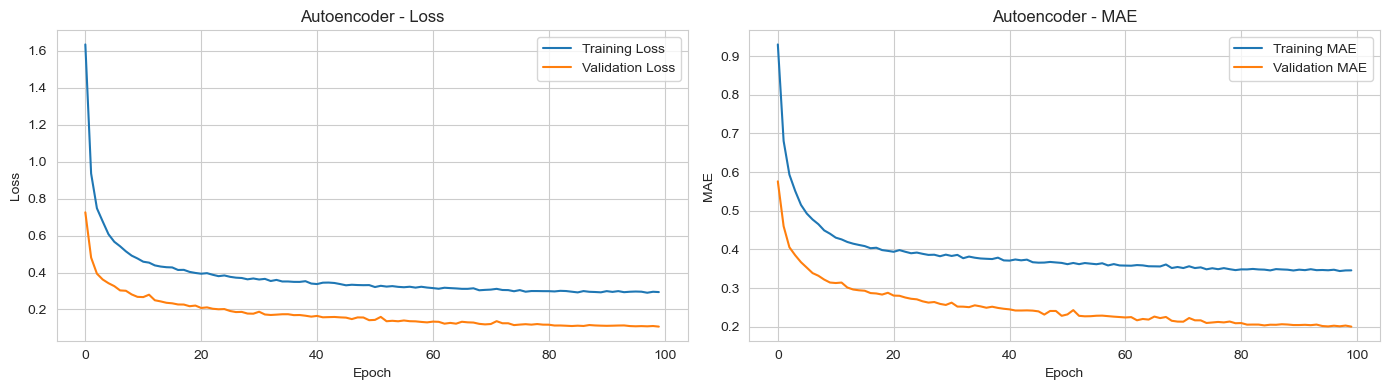

In [9]:
# Plot training and validation loss & MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(history_ae.history['loss'], label='Training Loss')
ax1.plot(history_ae.history['val_loss'], label='Validation Loss')
ax1.set(xlabel='Epoch', ylabel='Loss', title='Autoencoder - Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history_ae.history['mae'], label='Training MAE')
ax2.plot(history_ae.history['val_mae'], label='Validation MAE')
ax2.set(xlabel='Epoch', ylabel='MAE', title='Autoencoder - MAE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**5.3. Detect and Analyze Anomalies**

In [11]:
# Detect anomalies based on reconstruction error
reconstructed_ae = autoencoder_model.predict(X_scaled, verbose=0)
errors_ae = np.mean(np.square(X_scaled - reconstructed_ae), axis=1)
threshold_ae = np.percentile(errors_ae, 95)
anomalies_ae = errors_ae > threshold_ae

# Analyze anomaly distribution
print("\n📊 Anomaly Detection Analysis:")
n_total = len(anomalies_ae)
n_anomalies = np.sum(anomalies_ae)
anomaly_rate = n_anomalies / n_total * 100

print(f"  • Total samples: {n_total}")
print(f"  • Detected anomalies: {n_anomalies} ({anomaly_rate:.2f}%)")
print(f"  • Normal samples: {n_total - n_anomalies} ({100 - anomaly_rate:.2f}%)")
print("\n  Reconstruction Error Statistics:")
print(f"    - Mean: {np.mean(errors_ae):.4f}")
print(f"    - Std: {np.std(errors_ae):.4f}")
print(f"    - 95th percentile: {np.percentile(errors_ae, 95):.4f}")


📊 Anomaly Detection Analysis:
  • Total samples: 4000
  • Detected anomalies: 200 (5.00%)
  • Normal samples: 3800 (95.00%)

  Reconstruction Error Statistics:
    - Mean: 0.1382
    - Std: 2.0694
    - 95th percentile: 0.2735


**5.4. Visualize Anomaly Results**

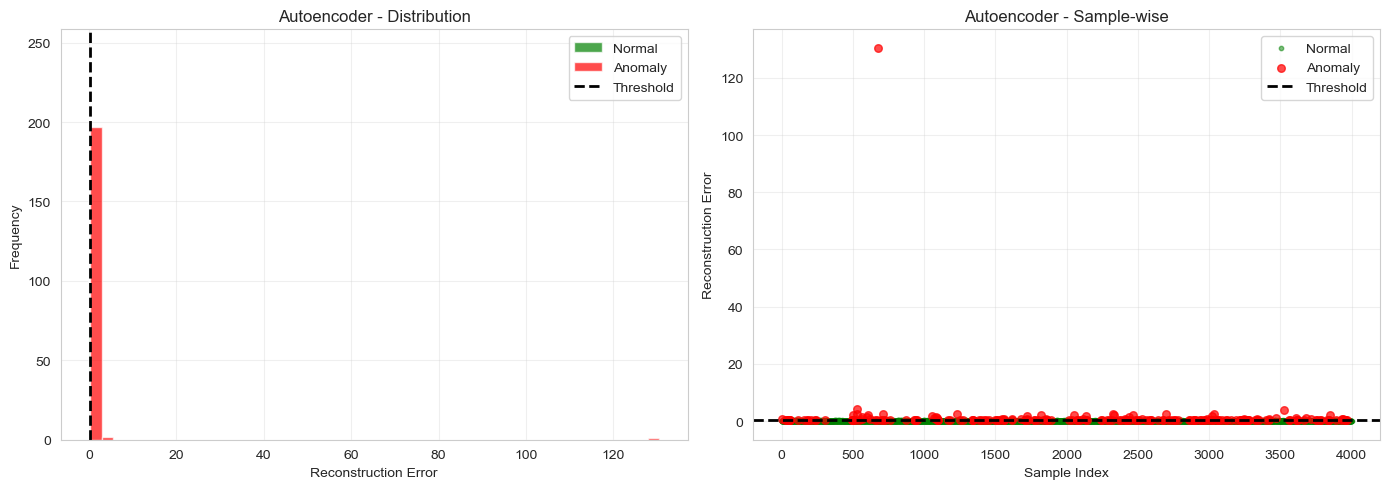

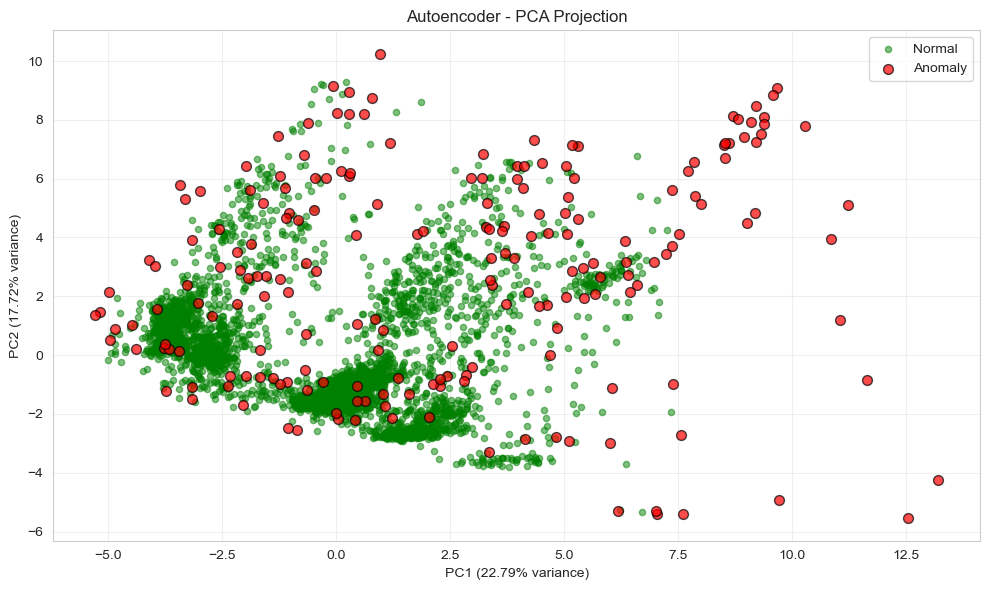

In [12]:
# Plot reconstruction error distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(errors_ae[~anomalies_ae], bins=50, alpha=0.7, label='Normal', color='green')
ax1.hist(errors_ae[anomalies_ae], bins=50, alpha=0.7, label='Anomaly', color='red')
ax1.axvline(threshold_ae, color='black', linestyle='--', linewidth=2, label='Threshold')
ax1.set(xlabel='Reconstruction Error', ylabel='Frequency', title='Autoencoder - Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

indices = np.arange(len(errors_ae))
ax2.scatter(indices[~anomalies_ae], errors_ae[~anomalies_ae], c='green', alpha=0.5, s=10, label='Normal')
ax2.scatter(indices[anomalies_ae], errors_ae[anomalies_ae], c='red', alpha=0.7, s=30, label='Anomaly')
ax2.axhline(threshold_ae, color='black', linestyle='--', linewidth=2, label='Threshold')
ax2.set(xlabel='Sample Index', ylabel='Reconstruction Error', title='Autoencoder - Sample-wise')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[~anomalies_ae, 0], X_pca[~anomalies_ae, 1], c='green', alpha=0.5, s=20, label='Normal')
plt.scatter(X_pca[anomalies_ae, 0], X_pca[anomalies_ae, 1], c='red', alpha=0.7, s=50, label='Anomaly', edgecolors='black')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title("Autoencoder - PCA Projection")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**5.5. Evaluate Clustering Quality and Identify Top Anomalies**

In [13]:
# Evaluate clustering quality using encoded features
encoded_features = encoder_model.predict(X_scaled, verbose=0)
cluster_labels = (errors_ae > threshold_ae).astype(int)

print("\n📊 Clustering Quality Metrics:")
sil_score = silhouette_score(encoded_features, cluster_labels)
db_score = davies_bouldin_score(encoded_features, cluster_labels)
ch_score = calinski_harabasz_score(encoded_features, cluster_labels)
print(f"  • Silhouette Score: {sil_score:.4f}")
print(f"  • Davies-Bouldin Index: {db_score:.4f}")
print(f"  • Calinski-Harabasz Score: {ch_score:.2f}")

# Identify and display top anomalous users
print("\n🚨 Top 20 Anomalous Users (Autoencoder):")
top_anomaly_indices = np.argsort(errors_ae)[-20:][::-1]
results_ae = pd.DataFrame({
    'user_id': [user_ids[i] for i in top_anomaly_indices],
    'reconstruction_error': errors_ae[top_anomaly_indices],
    'is_anomaly': anomalies_ae[top_anomaly_indices]
})
print(results_ae.to_string(index=False))


📊 Clustering Quality Metrics:
  • Silhouette Score: 0.3880
  • Davies-Bouldin Index: 2.6888
  • Calinski-Harabasz Score: 177.29

🚨 Top 20 Anomalous Users (Autoencoder):
user_id  reconstruction_error  is_anomaly
CDE1846            130.438730        True
BPD2437              4.233030        True
TAM3048              3.717378        True
CHB1062              2.621359        True
BPN3051              2.570533        True
LCW0047              2.536916        True
QGH0041              2.429369        True
EPI3052              2.343028        True
MTS0465              2.341451        True
WSA1765              2.292748        True
BMM0462              2.274173        True
JCB3054              2.244211        True
KAC1774              2.119320        True
MAB1775              2.040549        True
CAM3050              2.014853        True
LEB1764              1.988830        True
DLM2440              1.947415        True
QAH0048              1.827548        True
KEF1057              1.714219   

------------------------------------------------------------------------------------------------------------------------

**6. LSTM Autoencoder for Sequential Anomaly Detection**

**6.1. Create Daily Sequences**

In [14]:
print("\n" + "="*70)
print("MODEL 2: LSTM AUTOENCODER")
print("="*70)

print("\n📊 Creating daily sequences (lookback=7 days)...")
lookback = 7
lstm_sequences = {}
X_seq_scaled = None # Initialize to handle cases with no data

if data['logon'] is not None:
    logon_df = data['logon'].copy()
    logon_df['date'] = pd.to_datetime(logon_df['date'], format='%m/%d/%Y %H:%M:%S', errors='coerce')
    logon_df['date_only'] = logon_df['date'].dt.date
    
    daily_logon = logon_df.groupby(['user', 'date_only']).agg({
        'id': 'count',
        'pc': 'nunique'
    }).rename(columns={'id': 'daily_logons', 'pc': 'daily_unique_pcs'})
    
    # Helper logic to create sequences
    sequences = []
    users = []
    for user in daily_logon.index.get_level_values(0).unique():
        user_data = daily_logon.xs(user, level=0).sort_index()
        if len(user_data) >= lookback:
            values = user_data.values
            for i in range(len(values) - lookback + 1):
                sequences.append(values[i:i+lookback])
                users.append(user)
    
    lstm_sequences['logon'] = (np.array(sequences), users)

# Check if sequences were created
if lstm_sequences and 'logon' in lstm_sequences and len(lstm_sequences['logon'][0]) > 0:
    X_seq, users_seq = lstm_sequences['logon']
    print(f"✅ Sequences created: {X_seq.shape}")
    
    # Scale sequences
    n_samples, timesteps, features = X_seq.shape
    X_seq_reshaped = X_seq.reshape(-1, features)
    X_seq_scaled = scaler.fit_transform(X_seq_reshaped).reshape(n_samples, timesteps, features)
else:
    print("❌ Not enough sequential data to build the LSTM model.")


MODEL 2: LSTM AUTOENCODER

📊 Creating daily sequences (lookback=7 days)...
✅ Sequences created: (1370010, 7, 2)


**6.2. Build and Train the LSTM Model**

In [17]:
# Proceed only if sequences were created
if X_seq_scaled is not None:
    print("\n🏗️ Building LSTM Autoencoder...")
    
    # Define model architecture
    n_samples, timesteps, features = X_seq_scaled.shape
    encoding_dim_lstm = 8
    
    input_layer_lstm = layers.Input(shape=(timesteps, features))
    encoded_lstm = layers.LSTM(64, activation='relu', return_sequences=True)(input_layer_lstm)
    encoded_lstm = layers.Dropout(0.2)(encoded_lstm)
    encoded_lstm = layers.LSTM(32, activation='relu', return_sequences=False)(encoded_lstm)
    encoded_lstm = layers.Dropout(0.2)(encoded_lstm)
    encoded_lstm = layers.Dense(encoding_dim_lstm, activation='relu')(encoded_lstm)
    encoded_lstm = layers.RepeatVector(timesteps)(encoded_lstm)
    
    decoded_lstm = layers.LSTM(32, activation='relu', return_sequences=True)(encoded_lstm)
    decoded_lstm = layers.Dropout(0.2)(decoded_lstm)
    decoded_lstm = layers.LSTM(64, activation='relu', return_sequences=True)(decoded_lstm)
    decoded_lstm = layers.Dropout(0.2)(decoded_lstm)
    decoded_lstm = layers.TimeDistributed(layers.Dense(features))(decoded_lstm)
    
    lstm_autoencoder_model = Model(inputs=input_layer_lstm, outputs=decoded_lstm)
    lstm_autoencoder_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    print(f"✅ LSTM Autoencoder built - Timesteps: {timesteps}, Features: {features}")

    # Train the model
    print("\n🎓 Training LSTM Autoencoder...")
    history_lstm = lstm_autoencoder_model.fit(
        X_seq_scaled, X_seq_scaled,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks, # Re-using callbacks from AE
        verbose=1
    )
    print("✅ Training complete")


🏗️ Building LSTM Autoencoder...
✅ LSTM Autoencoder built - Timesteps: 7, Features: 2

🎓 Training LSTM Autoencoder...
Epoch 1/50
34251/34251 ━━━━━━━━━━━━━━━━━━━━ 268s 8ms/step - loss: 0.1573 - mae: 0.1486 - val_loss: 0.0696 - val_mae: 0.0798 - learning_rate: 0.0010
Epoch 2/50
34251/34251 ━━━━━━━━━━━━━━━━━━━━ 246s 7ms/step - loss: 0.0954 - mae: 0.1109 - val_loss: 0.0614 - val_mae: 0.0721 - learning_rate: 0.0010
Epoch 3/50
34251/34251 ━━━━━━━━━━━━━━━━━━━━ 248s 7ms/step - loss: 0.0782 - mae: 0.1002 - val_loss: 0.0445 - val_mae: 0.0640 - learning_rate: 0.0010
Epoch 4/50
34251/34251 ━━━━━━━━━━━━━━━━━━━━ 256s 7ms/step - loss: 0.0708 - mae: 0.0951 - val_loss: 0.0376 - val_mae: 0.0566 - learning_rate: 0.0010
Epoch 5/50
34251/34251 ━━━━━━━━━━━━━━━━━━━━ 252s 7ms/step - loss: 0.0660 - mae: 0.0913 - val_loss: 0.0340 - val_mae: 0.0539 - learning_rate: 0.0010
Epoch 6/50
34251/34251 ━━━━━━━━━━━━━━━━━━━━ 248s 7ms/step - loss: 0.0584 - mae: 0.0852 - val_loss: 0.0283 - val_mae: 0.0485 - learning_rate: 5

**6.3. Evaluate and Visualize LSTM Results**

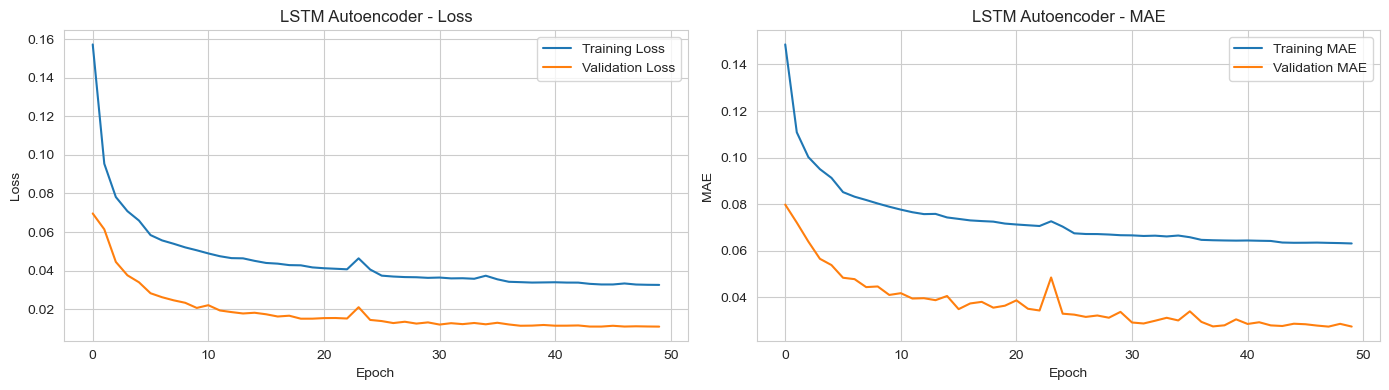


📊 Anomaly Detection Analysis (LSTM):
  • Detected anomalies: 68500 (5.00%)


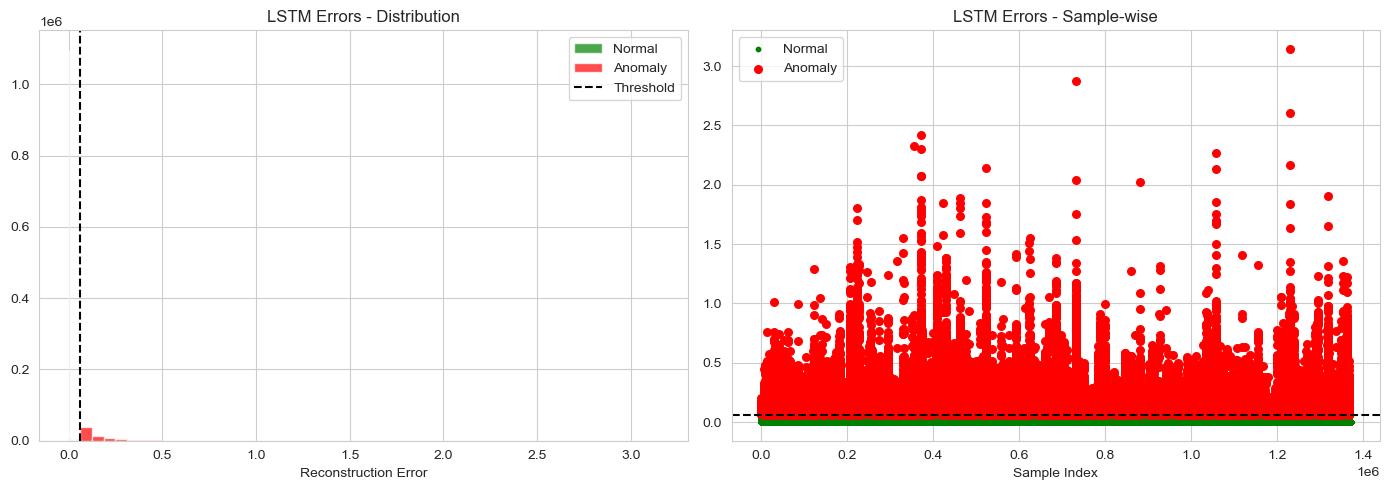


🚨 Top 20 Anomalous Sequences (LSTM):
user_id  reconstruction_error  is_anomaly
TIJ1817              3.144496        True
KEF1057              2.873179        True
TIJ1817              2.606269        True
DNS1758              2.421295        True
DJH0971              2.325099        True
DNS1758              2.298314        True
RCF0044              2.264757        True
TIJ1817              2.170139        True
HBB1759              2.140369        True
RCF0044              2.131737        True
DNS1758              2.073913        True
DNS1758              2.071132        True
KEF1057              2.036054        True
MHG3749              2.023377        True
WRM2803              1.906530        True
FZB3046              1.891607        True
DNS1758              1.872460        True
RCF0044              1.854461        True
FZB3046              1.849998        True
EPI3052              1.846512        True


In [18]:
if X_seq_scaled is not None:
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    ax1.plot(history_lstm.history['loss'], label='Training Loss')
    ax1.plot(history_lstm.history['val_loss'], label='Validation Loss')
    ax1.set(xlabel='Epoch', ylabel='Loss', title='LSTM Autoencoder - Loss')
    ax1.legend()
    ax2.plot(history_lstm.history['mae'], label='Training MAE')
    ax2.plot(history_lstm.history['val_mae'], label='Validation MAE')
    ax2.set(xlabel='Epoch', ylabel='MAE', title='LSTM Autoencoder - MAE')
    ax2.legend()
    plt.tight_layout()
    plt.show()

    # Detect anomalies in sequences
    reconstructed_lstm = lstm_autoencoder_model.predict(X_seq_scaled, verbose=0)
    errors_lstm = np.mean(np.square(X_seq_scaled - reconstructed_lstm), axis=(1, 2))
    threshold_lstm = np.percentile(errors_lstm, 95)
    anomalies_lstm = errors_lstm > threshold_lstm

    # Analyze anomaly distribution
    print("\n📊 Anomaly Detection Analysis (LSTM):")
    n_total_lstm = len(anomalies_lstm)
    n_anomalies_lstm = np.sum(anomalies_lstm)
    anomaly_rate_lstm = n_anomalies_lstm / n_total_lstm * 100
    print(f"  • Detected anomalies: {n_anomalies_lstm} ({anomaly_rate_lstm:.2f}%)")
    
    # Visualize reconstruction errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.hist(errors_lstm[~anomalies_lstm], bins=50, alpha=0.7, label='Normal', color='green')
    ax1.hist(errors_lstm[anomalies_lstm], bins=50, alpha=0.7, label='Anomaly', color='red')
    ax1.axvline(threshold_lstm, color='black', linestyle='--', label='Threshold')
    ax1.set(xlabel='Reconstruction Error', title='LSTM Errors - Distribution')
    ax1.legend()
    indices_lstm = np.arange(len(errors_lstm))
    ax2.scatter(indices_lstm[~anomalies_lstm], errors_lstm[~anomalies_lstm], c='green', s=10, label='Normal')
    ax2.scatter(indices_lstm[anomalies_lstm], errors_lstm[anomalies_lstm], c='red', s=30, label='Anomaly')
    ax2.axhline(threshold_lstm, color='black', linestyle='--')
    ax2.set(xlabel='Sample Index', title='LSTM Errors - Sample-wise')
    ax2.legend()
    plt.tight_layout()
    plt.show()

    # Top anomalies
    print("\n🚨 Top 20 Anomalous Sequences (LSTM):")
    top_lstm_indices = np.argsort(errors_lstm)[-20:][::-1]
    results_lstm = pd.DataFrame({
        'user_id': [users_seq[i] for i in top_lstm_indices],
        'reconstruction_error': errors_lstm[top_lstm_indices],
        'is_anomaly': anomalies_lstm[top_lstm_indices]
    })
    print(results_lstm.to_string(index=False))

**7. Save Artifacts and Summarize**

In [19]:
print("\n💾 Saving results...")

# Save models
autoencoder_model.save('autoencoder_model.h5')
if X_seq_scaled is not None:
    lstm_autoencoder_model.save('lstm_autoencoder_model.h5')

# Save scaler and anomaly results
joblib.dump(scaler, 'scaler.pkl')
results_ae.to_csv('anomalies_autoencoder.csv', index=False)

print("✅ Results saved")

# Final summary
print("\n" + "="*70)
print("📊 SUMMARY")
print("="*70)
print(f"\nAutoencoder Results:")
print(f"  • Anomaly Rate: {anomaly_rate:.2f}%")
print(f"  • Mean Reconstruction Error: {np.mean(errors_ae):.4f}")
print(f"  • Silhouette Score: {sil_score:.4f}")
print(f"  • Davies-Bouldin Index: {db_score:.4f}")

if X_seq_scaled is not None:
    print(f"\nLSTM Autoencoder Results:")
    print(f"  • Anomaly Rate: {anomaly_rate_lstm:.2f}%")
    print(f"  • Mean Reconstruction Error: {np.mean(errors_lstm):.4f}")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE!")
print("="*70)


💾 Saving results...
✅ Results saved

📊 SUMMARY

Autoencoder Results:
  • Anomaly Rate: 5.00%
  • Mean Reconstruction Error: 0.1382
  • Silhouette Score: 0.3880
  • Davies-Bouldin Index: 2.6888

LSTM Autoencoder Results:
  • Anomaly Rate: 5.00%
  • Mean Reconstruction Error: 0.0116

✅ ANALYSIS COMPLETE!


**8. Additional Post-Hoc Analyses**

**8.1. Analyze Top Anomalous User Behaviors**

In [20]:
print("\n" + "="*70)
print(f"🔍 ANALYZING TOP 10 ANOMALOUS USERS")
print("="*70)

top_users = results_ae.nlargest(10, 'reconstruction_error')['user_id'].tolist()
for user_id in top_users:
    if user_id in user_features.index:
        print(f"\n👤 User: {user_id}")
        print(f"    Reconstruction Error: {results_ae[results_ae['user_id']==user_id]['reconstruction_error'].values[0]:.4f}")
        
        user_data = user_features.loc[user_id]
        print(f"    📧 External Emails: {user_data.get('external_emails', 0):.0f} ({user_data.get('external_email_ratio', 0)*100:.1f}%)")
        print(f"    🌙 After Hours Logons: {user_data.get('after_hours_logons', 0):.0f} ({user_data.get('after_hours_ratio', 0)*100:.1f}%)")
        print(f"    📊 Email to Logon Ratio: {user_data.get('email_to_logon_ratio', 0):.2f}")


🔍 ANALYZING TOP 10 ANOMALOUS USERS

👤 User: CDE1846
    Reconstruction Error: 130.4387
    📧 External Emails: 1015 (32.1%)
    🌙 After Hours Logons: 0 (0.0%)
    📊 Email to Logon Ratio: 4.34

👤 User: BPD2437
    Reconstruction Error: 4.2330
    📧 External Emails: 1514 (34.5%)
    🌙 After Hours Logons: 1568 (45.6%)
    📊 Email to Logon Ratio: 1.28

👤 User: TAM3048
    Reconstruction Error: 3.7174
    📧 External Emails: 2216 (43.7%)
    🌙 After Hours Logons: 1787 (43.0%)
    📊 Email to Logon Ratio: 1.22

👤 User: CHB1062
    Reconstruction Error: 2.6214
    📧 External Emails: 1581 (45.1%)
    🌙 After Hours Logons: 1522 (51.9%)
    📊 Email to Logon Ratio: 1.20

👤 User: BPN3051
    Reconstruction Error: 2.5705
    📧 External Emails: 1230 (32.5%)
    🌙 After Hours Logons: 1486 (52.5%)
    📊 Email to Logon Ratio: 1.34

👤 User: LCW0047
    Reconstruction Error: 2.5369
    📧 External Emails: 1437 (37.5%)
    🌙 After Hours Logons: 1478 (47.3%)
    📊 Email to Logon Ratio: 1.23

👤 User: QGH0041
 

**8.2. Compare Normal vs. Anomalous Groups**


📊 NORMAL vs ANOMALOUS USER COMPARISON

                      Normal_Mean  Anomalous_Mean  Difference_%
total_emails          2720.829737     3279.020000     20.515443
total_logon_events     867.289474     1172.925000     35.240313
external_emails        953.385789     1228.125000     28.817213
after_hours_logons      47.815263      305.455000    538.823212
avg_email_size      474549.305399   543178.371889     14.461946
unique_pcs_logon        32.204211      163.940000    409.063869


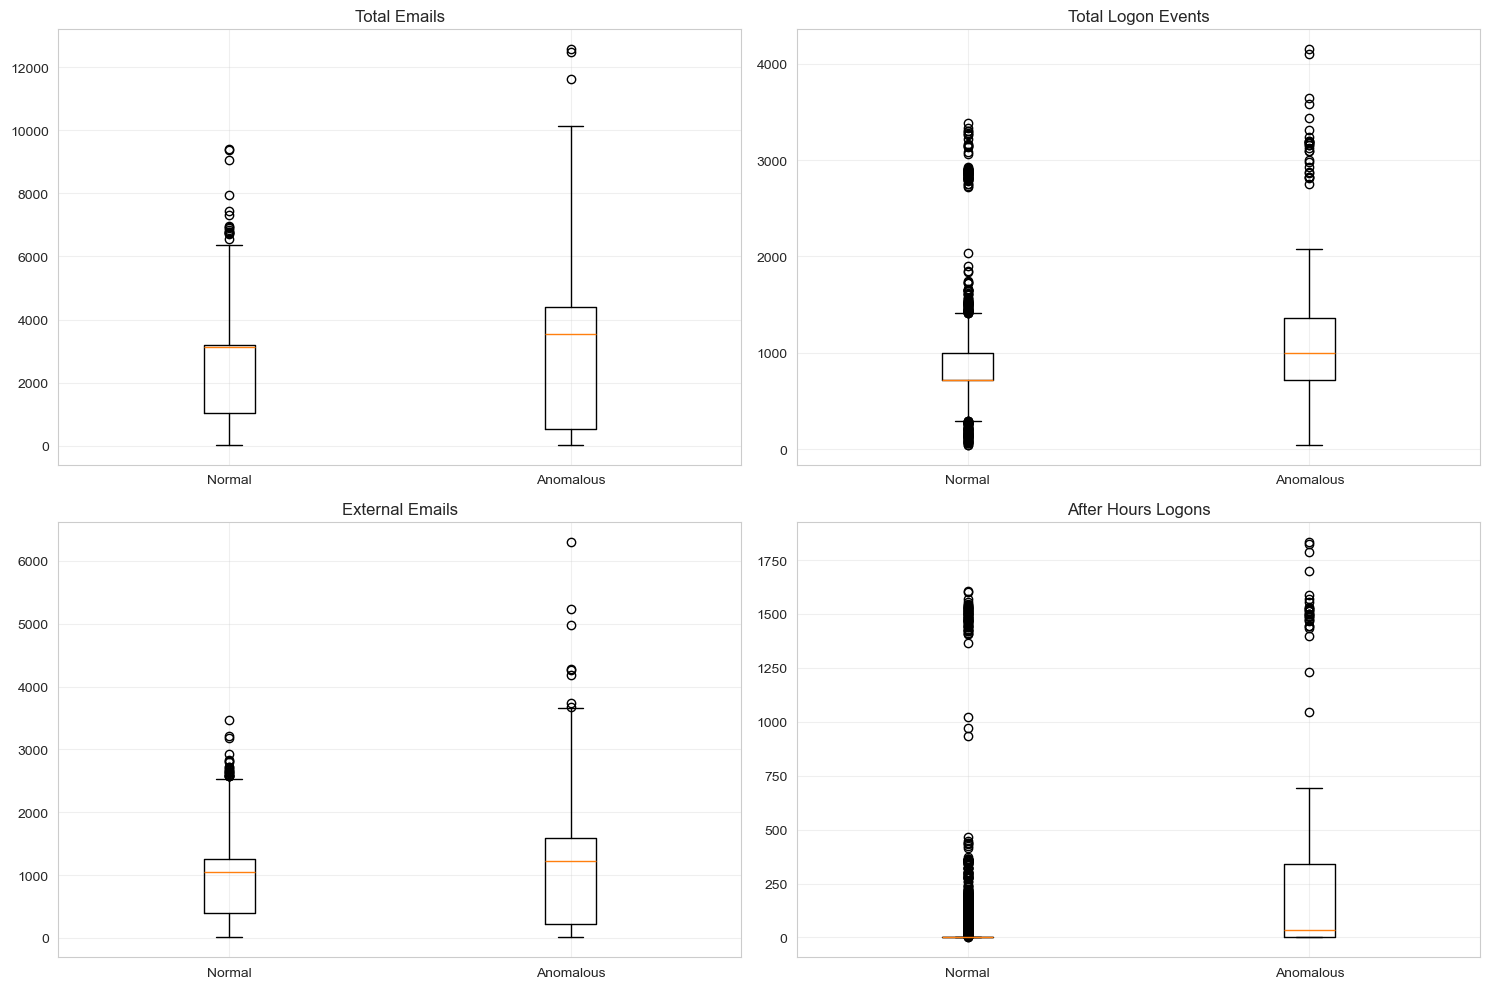

In [21]:
print("\n" + "="*70)
print("📊 NORMAL vs ANOMALOUS USER COMPARISON")
print("="*70)

normal_features = user_features[~anomalies_ae]
anomalous_features = user_features[anomalies_ae]
key_metrics = [
    'total_emails', 'total_logon_events', 'external_emails',
    'after_hours_logons', 'avg_email_size', 'unique_pcs_logon'
]

comparison = pd.DataFrame()
for metric in key_metrics:
    if metric in user_features.columns:
        comparison.loc[metric, 'Normal_Mean'] = normal_features[metric].mean()
        comparison.loc[metric, 'Anomalous_Mean'] = anomalous_features[metric].mean()
        comparison.loc[metric, 'Difference_%'] = (
            (anomalous_features[metric].mean() - normal_features[metric].mean()) / 
            normal_features[metric].mean() * 100
        )
print("\n" + comparison.to_string())

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for idx, metric in enumerate(key_metrics[:4]):
    ax = axes.flatten()[idx]
    ax.boxplot([normal_features[metric].values, anomalous_features[metric].values], labels=['Normal', 'Anomalous'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**8.3. Determine Feature Importance**


🎯 TOP 15 FEATURES FOR ANOMALY DETECTION

                feature  importance
         max_email_size    0.445305
   external_email_ratio    0.368956
         std_logon_hour    0.358989
functional_unit_encoded    0.353932
         avg_logon_hour    0.316795
           role_encoded    0.295302
     department_encoded    0.286017
            logon_count    0.273255
         std_email_size    0.270554
         avg_email_size    0.248072
     total_logon_events    0.212061
emails_with_attachments    0.190296
   email_to_logon_ratio    0.188461
      after_hours_ratio    0.188288
       total_email_size    0.172128


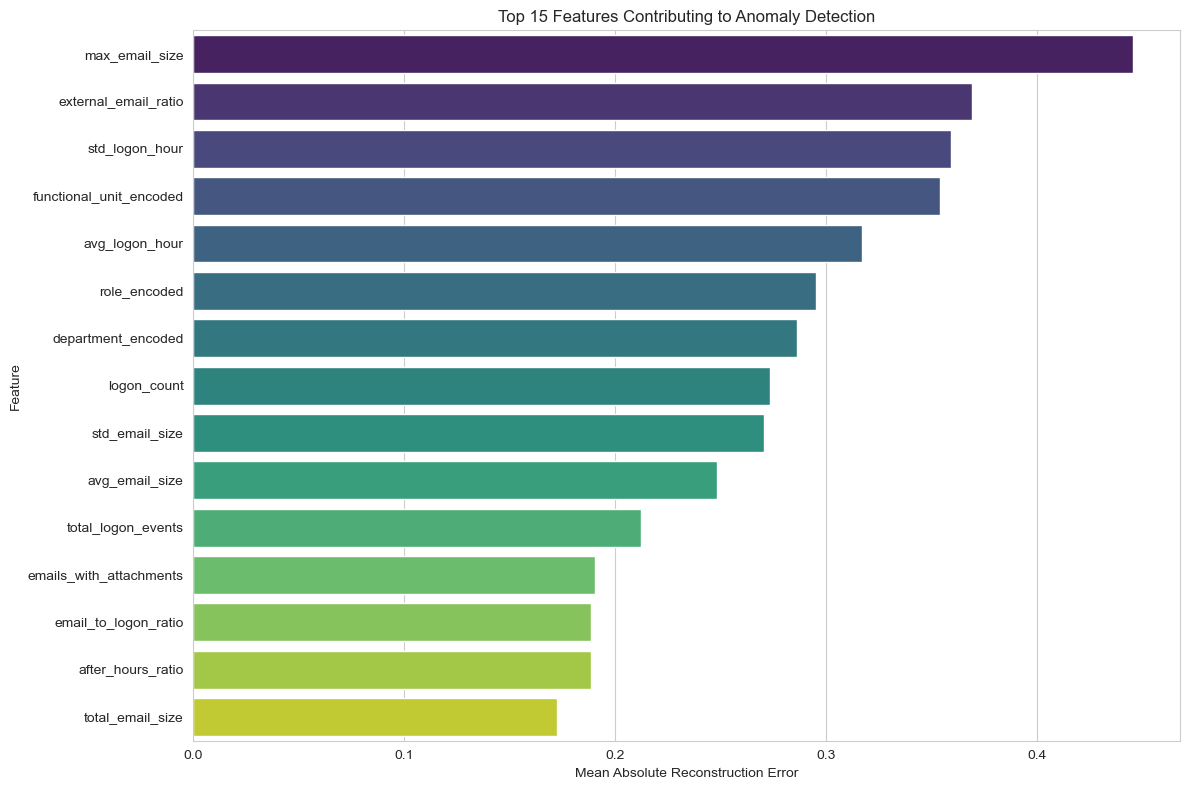

In [22]:
print("\n" + "="*70)
print(f"🎯 TOP 15 FEATURES FOR ANOMALY DETECTION")
print("="*70)

feature_errors = np.mean(np.abs(X_scaled - reconstructed_ae), axis=0)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_errors
}).sort_values('importance', ascending=False)

print("\n" + feature_importance.head(15).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.xlabel('Mean Absolute Reconstruction Error')
plt.ylabel('Feature')
plt.title('Top 15 Features Contributing to Anomaly Detection')
plt.tight_layout()
plt.show()

**8.4. Generate Final Risk Report**

In [23]:
print("\n" + "="*70)
print("📋 RISK ASSESSMENT REPORT")
print("="*70)

report = pd.DataFrame()
if data['users'] is not None:
    users_df = data['users'].set_index('user_id')
    report = results_ae.merge(
        users_df[['employee_name', 'role', 'department']], 
        left_on='user_id', 
        right_index=True, 
        how='left'
    )
    
    behavior_cols = ['total_emails', 'external_emails', 'after_hours_logons']
    report = report.merge(
        user_features[behavior_cols], 
        left_on='user_id', 
        right_index=True, 
        how='left'
    )
    
    report = report.sort_values('reconstruction_error', ascending=False)
    
    print("\n🚨 HIGH RISK USERS (Top 20):\n")
    print(report.head(20).to_string(index=False))
    
    report.to_csv('risk_assessment_report.csv', index=False)
    print("\n✅ Full report saved to 'risk_assessment_report.csv'")


📋 RISK ASSESSMENT REPORT

🚨 HIGH RISK USERS (Top 20):

user_id  reconstruction_error  is_anomaly          employee_name               role      department  total_emails  external_emails  after_hours_logons
CDE1846            130.438730        True    Carlos Dieter Ewing ElectricalEngineer 4 - Engineering          3165             1015                   0
BPD2437              4.233030        True  Benjamin Phillip Dyer            ITAdmin    5 - Security          4392             1514                1568
TAM3048              3.717378        True     Tara Adara Miranda            ITAdmin    5 - Security          5067             2216                1787
CHB1062              2.621359        True     Cally Haley Butler            ITAdmin    5 - Security          3505             1581                1522
BPN3051              2.570533        True Breanna Pascale Nelson            ITAdmin    5 - Security          3789             1230                1486
LCW0047              2.536916        T